<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/main/03.04.01.Examples_Of_Simple_SAR_Interpretation_Guide_L-Band.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALOS Land Change Notebook
<br>
This notebook uses ALOS PALSAR annual mosaics, provided by JAXA, to detect land change. These land changes could be related to agriculture, deforestation, flooding, urbanization, or other factors. This notebook includes several different data products including histograms, a single-date single-band threshold product, and a multi-date land change product. Ten datasets are available from the years: 2007-2010, and 2015-2020.
The data has been processed to gamma-naught backscatter (HH and HV bands) at 25-meters spatial resolution. It should be noted that data collections for a given annual mosaic vary by region but are typically consistent year-to-year. 
<br><br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

In [1]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

--2022-01-06 04:21:12--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15292 (15K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  14.93K  --.-KB/s    in 0s      

2022-01-06 04:21:13 (50.3 MB/s) - ‘odc_colab.py’ saved [15292/15292]

Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Package postgresql was not found; installing it...
Module odc-gee was not found; cloning https://github.com/ceos-seo/odc-gee.git to CWD...


In [2]:
from odc_colab import populate_db
populate_db()

No database file supplied. Downloading default index.
Cleaned up extracted database files.


## Load the Data Cube Configuration and Import Utilities

In [3]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=y9pZ5s2SK6Nf4fs3VuaDT8XNr3i-Ugv66fMeS4Fd2KM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWguBiip5J_nCl39FUK2vmCEB5evzd4CWdIM-dD0oi9neyHMMfC7lnw

Successfully saved authorization token.


/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [4]:
# Select and data platform and product
platform = 'ALOS'
product = 'palsar_google'

## Define the Extents of the Analysis and View

In [5]:
example_name = "4.2.2 Deforestation & regrowth" #@param ["4.2.1 Dense tropical forest", "4.2.2 Deforestation & regrowth", "4.2.3 Flooded wetlands", "4.2.4 Mangroves", "4.2.5 Rubber", "4.2.6 Oil palm & Acacia", "4.2.7 Irrigated rice", "4.2.8 Agriculture", "4.2.9 Rangelands & pastures", "4.2.10 Savannah", "4.2.11 Arid terrain & rock outcrops", "4.2.12 Open water", "4.2.13 Signal attenuation"]
variable_name = "L-Band"
lat_long = ()
box_size_deg = ()

if example_name =="4.2.1 Dense tropical forest":
    lat_long = (0.90, -74.20)  # Changed this from 74.20 to -74.20
    box_size_deg = 0.20   
elif example_name=="4.2.2 Deforestation & regrowth":
    lat_long = (1.15, -74.50)  # Changed this from 74.50 to -74.50
    box_size_deg = 0.20
elif example_name=="4.2.3 Flooded wetlands":
    lat_long = (-1.90, -74.50)  # Changed this from 1.9 to -1.9 & 74.20 to -74.20
    box_size_deg = 0.20
elif example_name=="4.2.4 Mangroves":
    lat_long = (-7.80, 39.30)  # Assuming the default as North East
    box_size_deg = 0.20
elif example_name=="4.2.5 Rubber":
    lat_long = (11.15, 106.85)
    box_size_deg = 0.20
elif example_name=="4.2.6 Oil palm & Acacia":
    lat_long = (0.15, 102.95)  
    box_size_deg = 0.20
elif example_name=="4.2.7 Irrigated rice":
    lat_long = (10.60, 105.55)  
    box_size_deg = 0.20  
elif example_name=="4.2.8 Agriculture":
    lat_long = (46.95, 7.10)  
    box_size_deg = 0.20
elif example_name=="4.2.9 Rangelands & pastures":
    lat_long = (-10.05, -51.85)  # Assuming as North East
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2020-05-05', '2020-05-12') 
elif example_name=="4.2.10 Savannah":
    lat_long = (-1.45, 34.84)  #Assuming as North East
    box_size_deg = 0.20
elif example_name=="4.2.11 Arid terrain & rock outcrops":
    lat_long = (2.6, 36.80)  
    box_size_deg = 0.20
elif example_name=="4.2.12 Open water":
    lat_long = (10.00, 104.75)  
    box_size_deg = 0.20
elif example_name=="4.2.13 Signal attenuation":
    lat_long = (-2.42,-60.82) #Given S2.25º, W60.75º in SAR Guide 
    box_size_deg = 0.30
# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [6]:
display_map(latitude,longitude)

## Load the Data and View the Available Dates

In [7]:
sar_dataset = dc.load(product=product, platform=platform, measurements=['hh','hv'], time=['2017','2020'], lat=latitude, lon=longitude)

In [8]:
# Show acquisition indices and dates
pd.DataFrame(list(sar_dataset.time.values.astype('datetime64[D]')),columns=['Acquisition Date'])

,Acquisition Date
0,2017-01-01
1,2018-01-01
2,2019-01-01
3,2020-01-01


## View Histogram Plots
Histogram plots are good for viewing the statistics of the HH and HV data. In most cases it is easy to identify the difference between land pixels (higher values) and water pixels (lower values). The histogram below shows the data from the first year in the time series (2007).

In [13]:
# Choose a single year index (listed above)
year_index = 0

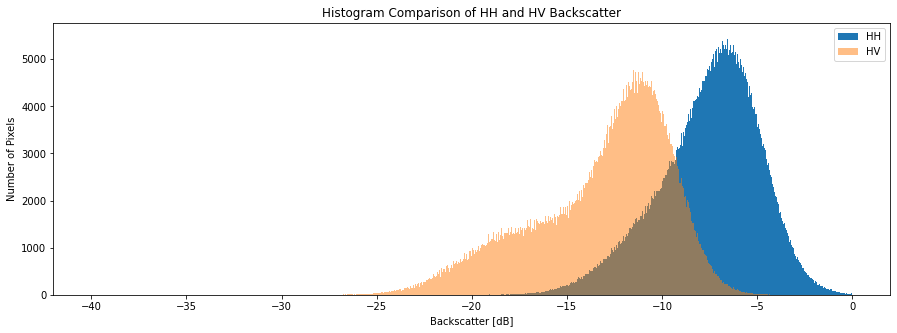

In [22]:
fig = plt.figure(figsize=(15, 5))
(20*np.log10(sar_dataset.isel(time=year_index).hh)-83.0).plot.hist(bins=1000, range=(-40,0), label="HH")
(20*np.log10(sar_dataset.isel(time=year_index).hv)-83.0).plot.hist(bins=1000, range=(-40,0), label="HV", alpha=0.5)
plt.legend()
plt.xlabel("Backscatter [dB]")
plt.ylabel("Number of Pixels")
plt.title("Histogram Comparison of HH and HV Backscatter")
plt.show()

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in HH and HV image products. 

In [ ]:
# Creation of a new band (HH/HV = hhhv) for RGB display
sar_dataset['hhhv'] = sar_dataset.hh / sar_dataset.hv

In [ ]:
hh = sar_dataset.hh.astype(np.int64); hh_min = hh.min(); hh_max = hh.max()
sar_dataset['hh_amp'] = hh*255/12000
hv = sar_dataset.hv.astype(np.int64); hv_min = hv.min(); hv_max = hv.max()
sar_dataset['hv_amp'] = hv*255/6000
hhhv = sar_dataset.hhhv.astype(np.int64); hhhv_min = hhhv.min(); hhhv_max = hhhv.max()
sar_dataset['hhhv_amp'] = 50*(hh/12000)/(hv/6000)

## HH, HV and RGB images

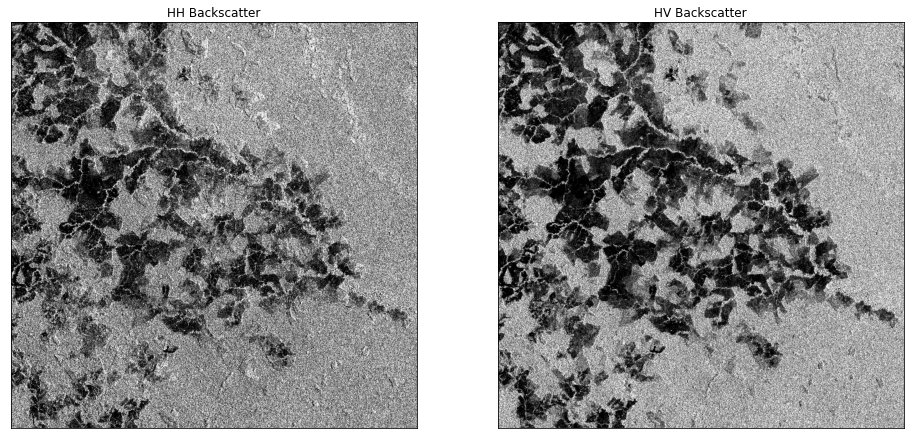

In [ ]:
# Plots of HH and HV Backscatter Intensity
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rgb(sar_dataset.isel(time=year_index), ax=ax[0], bands=['hh_amp','hh_amp','hh_amp'])
rgb(sar_dataset.isel(time=year_index), ax=ax[1], bands=['hv_amp','hv_amp','hv_amp'])
ax[0].set_title('HH Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('HV Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

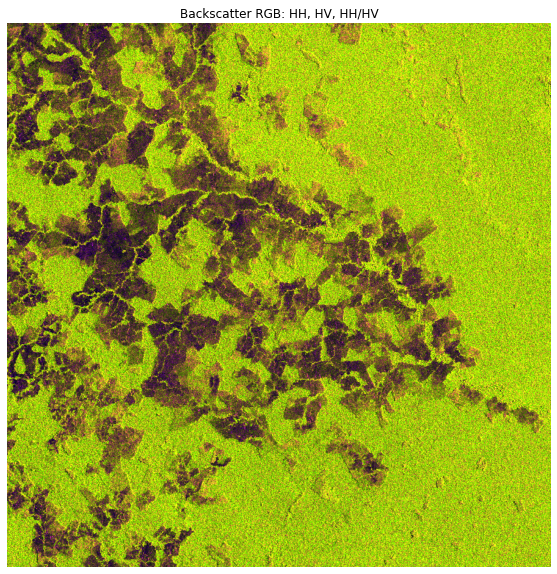

In [ ]:
# RGB Plot of Backscatter Intensity (RGB= HH, HV, HH/HV)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# New vegetation and urban areas are MAGENTA in color (due to high overall scattering and higher HH compared to HV)
# Low vegetation areas are BLUE (due to low overall scattering and higher HH compared to HV)
# Water is BLACK (low backscatter in both bands with similar HH and HV)

rgb(sar_dataset.isel(time=year_index),bands=['hh_amp','hv_amp','hhhv_amp'], width=10)
plt.title('Backscatter RGB: HH, HV, HH/HV')
plt.axis('off')
plt.show()